<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: calwebb_image3, NIRCam imaging

<span style="color:red"> **Instruments Affected**</span>: e.g., NIRCam 

### Table of Contents

<div style="text-align: left"> 
    
<br> [Introduction\*](#intro)
<br> [JWST CalWG Algorithm\*](#algorithm)
<br> [Defining Terms](#terms)
<br> [Test Description\*](#description)
<br> [Data Description\*](#data_descr)
<br> [Imports\*](#imports)
<br> [Convenience Functions](#convenience_functions)
<br> [Loading the Data\*](#data_load)
<br> [calwebb_image3 - Ensemble calibrations](#image3) 
<br> [Run the entire pipeline](#image3_at_once)
<br> [Run the individual pipeline steps](#image3_step_by_step)
   <br> [The `WCS Refinement` step](#tweakreg)
   <br> [The `Sky Matching` step](#skymatch)
   <br> [The `Outlier Detection` step](#outlier_detection)
   <br> [The `Resample` step](#resample)
   <br> [The `Source Catalog` step](#source_catalog)
<br> [About This Notebook\*](#about)
<br>    

</div>

<a id='intro'></a>
# Introduction

This notebook covers part 3 of the imaging mode data calibration module. In this notebook we'll check Stage 3 of the JWST calibration pipeline for imaging data, also known as *calwebb\_image3*. 

The [Stage 3 pipeline](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_image3.html) takes one or more calibrated slope images (`*_cal.fits` files) and combines them into a final mosaic image. It then creates a source catalog from this mosaic. Several steps are performed in order to prepare the data for the mosaic creation. These steps largely mirror what is done by [DrizzlePac](https://www.stsci.edu/scientific-community/software/drizzlepac.html) software when working with HST data. 

First, using common sources found across the input images, the WCS of each image is refined. Background levels are then matched across the inputs. Spurious sources (e.g. cosmic rays that were not flagged in the `jump` step during Stage 1 processing) are removed by comparing each individual input image to a median image. The indivudal images are combined into a single mosaic image. A source catalog is created based on the mosaic image. And finally, the individual exposures are updated using the information from the preceding steps. New versions of the individual calibrated slope images (`*_cal.fits` files) are produced that contain matched backgrounds, flagged spurious sources, and improved WCS objects. Also, updated [resampled](https://jwst-pipeline.readthedocs.io/en/stable/jwst/resample/main.html) images (`_i2d.fits` files) are created which all contain the final undistorted sky projection that is present in the mosaic image.

There are three final outputs. The first is updated copies of the input files. These updated files contain a consistent WCS, such that they overlap correctly. The second output is a final mosaic image created by drizzling the input images onto a distortion-free grid. And the final output is a source catalog wth basic photometry, created from the final mosaic image.

To check how the steps of the pipeline change the input data, we will use several NIRCam simulated data files and run them through the pipeline, examining the results at several places along the way.

All JWST imaging mode data, regardless of instrument, are processed through the *calwebb\_image3* pipeline. The steps and the order in which they are performed is the same for all data.

Pipeline description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image3.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst

[Top of Page](#title_ID)

<a id="algorithm"></a>
# JWST CalWG Algorithm

Multiple exposures from the direct imaging modes are combined into a combined image (e.g., mosaic).
The current status of the algorithms for this pipeline stage is summarized in the link below. Links are provided to individual pages where the details of the algorithms are given along with notes on why those algorithms were picked.

The algorithms for each step in each pipeline stage are split into baseline" and "enhanced" versions (formerly known as "vanilla" and "optimal", respectively).  See Baseline and Enhanced Algorithms for more details.
Input/Outputs of this stage refer to the main data products for the pipeline process. The full list of archive products for this (and all stages of the pipeline) is tabulated in Archive Products.

[JWST CalWG algorithms for calwebb_image3](https://outerspace.stsci.edu/display/JWSTCC/CALWEBB_IMAGE3)

[Top of Page](#title_ID)

<a id="terms"></a>
# Defining Terms


**JWST**: James Webb Space Telescope

**NIR**: Near Infrared


[Top of Page](#title_ID)

<a id="description"></a>
# Test Description

This test is performed by running simulated data through the full pipeline and performing a visual inspection of the outputs. Next, the notebook does quick checks after each step in the calwebb_image3 pipeline, based on the algorithms defined. 


[Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description

For this module, we will use an association of calibrated NIRCam simulated imaging exposures generated with Mirage.


[Top of Page](#title_ID)

<a id="tempdir"></a>
# Set up Temporary Directory
The following cell sets up a temporary directory (using python's `tempfile.TemporaryDirectory()`), and changes the script's active directory into that directory (using python's `os.chdir()`). This is so that, when the notebook is run through, it will download files to (and create output files in) the temporary directory rather than in the notebook's directory. This makes cleanup significantly easier (since all output files are deleted when the notebook is shut down), and also means that different notebooks in the same directory won't interfere with each other when run by the automated webpage generation process.

If you want the notebook to generate output in the notebook's directory, simply don't run this cell.

If you have a file (or files) that are kept in the notebook's directory, and that the notebook needs to use while running, you can copy that file into the directory (the code to do so is present below, but commented out).

[Top of Page](#title_ID)

In [1]:
#****
#
# Set this variable to False to not use the temporary directory
#
#****
use_tempdir = True

# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil

if use_tempdir:
    data_dir = TemporaryDirectory()

    # If you have files that are in the notebook's directory, but that the notebook will need to use while
    # running, copy them into the temporary directory here.
    #
    # files = ['name_of_file']
    # for file_name in files:
    #     shutil.copy(file_name, os.path.join(data_dir.name, file_name))

    # Save original directory
    orig_dir = os.getcwd()

    # Move to new directory
    os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmpzhgmo62r


In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


<a id='Imports_ID'></a>
# Imports

Import packages necessary for this notebook

In [3]:
# Module with functions to get information about objects:
from glob import glob
import os
import shutil

# Numpy library:
import numpy as np

# To read association file
import json

# To download data
import requests

# To examine parameter reference files
import asdf

# Astropy tools:
from astropy.io import ascii, fits
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch

Set up matplotlib for plotting

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version (outside of Jupyter Lab) if you want interactive plots
# %matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

Import JWST pipeline-related modules

In [5]:
# The entire calwebb_image3 pipeline
from jwst.pipeline import calwebb_image3

# Individual steps that make up calwebb_image3
from jwst.tweakreg import TweakRegStep
from jwst.skymatch import SkyMatchStep
from jwst.outlier_detection import OutlierDetectionStep
from jwst.resample import ResampleStep
from jwst.source_catalog import SourceCatalogStep
from jwst import datamodels
from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base

Check which version of the pipeline we are running:

In [6]:
import jwst
print(jwst.__version__)

1.3.2


<a id='convenience_functions'></a>
# Define convenience functions and parameters

Here we define some functions that we will use repeatedly throughout the notebook.

In [7]:
# Files created in this notebook will be saved
# in a subdirectory of the base directory called `Stage3`
output_dir = './'

In [8]:
def find_bad_pix_types(dq_value):
    """Given an integer representation of a series of bad pixel flags,
    identify which types of bad pixels the flags indicate.
    
    Parameters
    ----------
    dq_value : uint16
        Value associated with a set of bad pixel flags
        
    Returns
    -------
    bad_nums : list
        List of integers representing the bad pixel types
        
    bad_types : list
        List of bad pixel type names corresponding to bad_nums
    """
    # Change integer into a byte array
    bitarr = np.binary_repr(dq_value)
    
    # Find the bad pixel type associated with each bit where
    # the flag is set
    bad_nums = []
    bad_types = []
    for i, elem in enumerate(bitarr[::-1]):
        if elem == str(1):
            badval = 2**i
            bad_nums.append(badval)
            key = next(key for key, value in datamodels.dqflags.pixel.items() if value == badval)
            bad_types.append(key)
    return bad_nums, bad_types

In [9]:
def overlay_catalog(data_2d, catalog, flux_limit=0, vmin=0, vmax=10,
                    title=None, units='MJy/str'):
    """Function to generate a 2D image of the data, 
    with sources overlaid.
    
    data_2d : numpy.ndarray
        2D image to be displayed
        
    catalog : astropy.table.Table
        Table of sources
    
    flux_limit : float
        Minimum signal threshold to overplot sources from catalog.
        Sources below this limit will not be shown on the image.
        
    vmin : float
        Minimum signal value to use for scaling
        
    vmax : float
        Maximum signal value to use for scaling
        
    title : str
        String to use for the plot title
                
    units : str
        Units of the data. Used for the annotation in the
        color bar
    """
    norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LogStretch())
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data_2d, origin='lower', norm=norm)
    
    for row in catalog:
        if row['aper_total_flux'].value > flux_limit:
            plt.plot(row['xcentroid'], row['ycentroid'], marker='o',
                     markersize='3', color='red')

    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    
    fig.colorbar(im, label=units)
    fig.tight_layout()
    plt.subplots_adjust(left=0.15)
    
    if title:
        plt.title(title)

In [10]:
def show_image(data_2d, vmin, vmax, xpixel=None, ypixel=None, title=None,
               scale='log', units='MJy/str'):
    """Function to generate a 2D, log-scaled image of the data, 
    with an option to highlight a specific pixel.
    
    data_2d : numpy.ndarray
        2D image to be displayed
        
    vmin : float
        Minimum signal value to use for scaling
        
    vmax : float
        Maximum signal value to use for scaling
        
    xpixel : int
        X-coordinate of pixel to highlight
        
    ypixel : int
        Y-coordinate of pixel to highlight
        
    title : str
        String to use for the plot title
        
    scale : str
        Specify scaling of the image. Can be 'log' or 'linear'
        
    units : str
        Units of the data. Used for the annotation in the
        color bar
    """
    if scale == 'log':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LogStretch())
    elif scale == 'linear':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LinearStretch())
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data_2d, origin='lower', norm=norm)
    
    if xpixel and ypixel:
        plt.plot(xpixel, ypixel, marker='o', color='red', label='Selected Pixel')

    fig.colorbar(im, label=units)
    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    if title:
        plt.title(title)

[Top of Page](#title_ID)

<a id="data_load"></a>
# Loading the Data

For this module, we will use calbrated rate files from a NIRCam simulated imaging exposure that is stored in Box. Let's download these files, as well as an association file and some parameter reference files.

In [11]:
from astropy.utils.data import download_file
from pathlib import Path
from shutil import move
from os.path import splitext

def get_box_files(file_list):
    for box_url,file_name in file_list:
        if 'https' not in box_url:
            box_url = 'https://stsci.box.com/shared/static/' + box_url
        downloaded_file = download_file(box_url)
        if Path(file_name).suffix == '':
            ext = splitext(box_url)[1]
            file_name += ext
        move(downloaded_file, file_name)
        
file_urls = ['https://stsci.box.com/shared/static/p2wlvndw25dk7xwk1tasqevmhkg6p55e.fits',
             'https://stsci.box.com/shared/static/cmhc7kkf5z6373d2vwg7916lrhe5ia7u.fits',
             'https://stsci.box.com/shared/static/sb18cpfqjbw1i09gvw0cpqkj6ymdn899.fits',
             'https://stsci.box.com/shared/static/7d00b9isvss7njhcwmd8uiq8c7s4d845.json',
             'https://stsci.box.com/shared/static/ja0gkd8c0x8p8konhr84wkuhwnpkqf4s.asdf',
             'https://stsci.box.com/shared/static/yahdw55fotwrh7i6hhcxksj97qkf7j4r.asdf',
              ]

file_names = ['jw98765001001_01101_00001_nrcb5_cal.fits',
              'jw98765001001_01101_00002_nrcb5_cal.fits',
              'jw98765001001_01101_00003_nrcb5_cal.fits',
              'level3_lw_asn.json',
              'jwst_nircam_pars-tweakregstep_0006.asdf',
              'nircam_pars-sourcecatalogstep_f444w_clear.asdf'
              ]  

box_download_list = [(url,name) for url,name in zip(file_urls,file_names)]

In [12]:
get_box_files(box_download_list)

In [13]:
asn_file = os.path.join(output_dir, 'level3_lw_asn.json')

In [14]:
# Open the association file and load into a json object
with open(asn_file) as f_obj:
    asn_data = json.load(f_obj)

In [15]:
asn_data

{'asn_type': 'None',
 'asn_rule': 'DMS_Level3_Base',
 'version_id': None,
 'code_version': '0.17.1',
 'degraded_status': 'No known degraded exposures in association.',
 'program': 'noprogram',
 'constraints': 'No constraints',
 'asn_id': 'a3001',
 'target': 'none',
 'asn_pool': 'none',
 'products': [{'name': 'l3_lw_results',
   'members': [{'expname': 'jw98765001001_01101_00001_nrcb5_cal.fits',
     'exptype': 'science'},
    {'expname': 'jw98765001001_01101_00002_nrcb5_cal.fits',
     'exptype': 'science'},
    {'expname': 'jw98765001001_01101_00003_nrcb5_cal.fits',
     'exptype': 'science'}]}]}

Here we see that the association file begins with a few lines of data that give high-level information about the association. The most important entry here is the `asn_rule` field. Association files have different formats for the different stages of the pipeline. You should be sure that the `asn_rule` matches the pipeline that you will be running. In this case we'll be running the Stage 3 pipeline, and we see that the `asn_rule` mentions "Level3", which is what we want.

Beneath these lines, we see the `products` field. This field contains a list of dictionaries that specify the files that belong to this association, and the types of those files. When the Stage 3 pipeline is run on this association file, all files listed here will be run through the calibration steps.

In [16]:
tweak_files = ['level3_lw_asn_0_tweakregstep.fits',
               'level3_lw_asn_1_tweakregstep.fits',
               'level3_lw_asn_2_tweakregstep.fits']
tweak_product = 'manual_asn_file'

In [17]:
tweakreg_asn = asn_from_list.asn_from_list(tweak_files, rule=DMS_Level3_Base, product_name=tweak_product)

Here is our new association, containing the three files created by the `tweakreg` step.

In [18]:
tweakreg_asn

{
    "asn_type": "None",
    "asn_rule": "DMS_Level3_Base",
    "version_id": null,
    "code_version": "1.3.2",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "target": "none",
    "asn_pool": "none",
    "products": [
        {
            "name": "manual_asn_file",
            "members": [
                {
                    "expname": "level3_lw_asn_0_tweakregstep.fits",
                    "exptype": "science"
                },
                {
                    "expname": "level3_lw_asn_1_tweakregstep.fits",
                    "exptype": "science"
                },
                {
                    "expname": "level3_lw_asn_2_tweakregstep.fits",
                    "exptype": "science"
                }
            ]
        }
    ]
}

Now save the new association to a json file.

In [19]:
output_test = 'manual_tweakreg_asn.json'
with open(output_test, 'w') as outfile:
    name, serialized = tweakreg_asn.dump(format='json')
    outfile.write(serialized)

[Top of Page](#title_ID)

---
<a id='image3'></a>
# The calwebb_image3 pipeline: Ensemble processing

In the sections below, we will run the Stage 3 pipeline using an association file containing several NIRCam exposures. We will first call the entire *calwebb_image3* pipeline itself. The pipeline is a wrapper which will string together all of the appropriate steps in the proper order.

After running the entire pipeline, we will go back to the original calibrated slope images and manually run them through each of the steps that comprise the Stage 3 pipeline. For each step we will check in more detail what is going on and examine how the exposure files have changed.

See [Figure 1](https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline/algorithm-documentation/stages-of-processing/calwebb_image3) on the calwebb_image3 algorithm page for a map of the steps are performed on the input data.

<a id='image3_at_once'></a>
# Run the entire `calwebb_image3` pipeline

In this section we show how to run the entire calwebb_image3 pipeline with a single call. 

We set parameter values for some of the individual steps, save some outputs, etc, and then call the pipeline.

In [20]:
# Create an instance of the pipeline class
image3 = calwebb_image3.Image3Pipeline()

# Set some parameters that pertain to the
# entire pipeline
image3.output_dir = output_dir
image3.save_results = True
image3.tweakreg.save_results = True
image3.skymatch.save_results = True
image3.outlier_detection.save_results = True
image3.resample.save_results = True
image3.source_catalog.save_results = True

# Set some parameters that pertain to some of
# the individual steps
image3.tweakreg.snr_threshold = 10.0  # 5.0 is the default
image3.tweakreg.kernel_fwhm = 2.302  # 2.5 is the default
image3.tweakreg.brightest = 20  # 100 is the default
image3.tweakreg.align_to_gaia = True
image3.tweakreg.save_gaia_catalog = True
image3.source_catalog.kernel_fwhm = 2.302  # pixels
image3.source_catalog.snr_threshold = 10.

# Call the run() method
image3.run(asn_file)

2022-01-27 19:36:54,185 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2022-01-27 19:36:54,187 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2022-01-27 19:36:54,189 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2022-01-27 19:36:54,190 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2022-01-27 19:36:54,192 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2022-01-27 19:36:54,193 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2022-01-27 19:36:54,195 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2022-01-27 19:36:54,355 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('./level3_lw_asn.json',).


2022-01-27 19:36:54,361 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.302, 'snr_threshold': 10.0, 'brightest'

2022-01-27 19:36:55,149 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw98765001001_01101_00001_nrcb5_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2022-01-27 19:36:55,697 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_nircam_abvegaoffset_0001.asdf'.


2022-01-27 19:36:55,700 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_nircam_apcorr_0004.fits'.


2022-01-27 19:36:55,703 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits'.


2022-01-27 19:36:55,706 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2022-01-27 19:36:56,127 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2022-01-27 19:36:56,130 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '.', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.302, 'snr_threshold': 10.0, 'brightest': 20, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 15, 'searchrad': 1.0, 'use2dhist': True, 'separation': 0.5, 'tolerance': 1.0, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'general', 'nclip': 3, 'sigma': 3.0, 'align_to_gaia': True, 'gaia_catalog': 'GAIADR2', 'min_gaia': 5, 'save_gaia_catalog': True}


2022-01-27 19:36:59,200 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 20 sources in jw98765001001_01101_00001_nrcb5_cal.fits.


2022-01-27 19:37:02,448 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 20 sources in jw98765001001_01101_00002_nrcb5_cal.fits.


2022-01-27 19:37:05,784 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 20 sources in jw98765001001_01101_00003_nrcb5_cal.fits.


2022-01-27 19:37:05,840 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-01-27 19:37:05,841 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 3.


2022-01-27 19:37:05,842 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:


2022-01-27 19:37:05,864 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw98765001001_01101_00001_nrcb5_cal':


2022-01-27 19:37:05,865 - stpipe.Image3Pipeline.tweakreg - INFO -      jw98765001001_01101_00001_nrcb5_cal


2022-01-27 19:37:05,886 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw98765001001_01101_00002_nrcb5_cal':


2022-01-27 19:37:05,886 - stpipe.Image3Pipeline.tweakreg - INFO -      jw98765001001_01101_00002_nrcb5_cal


2022-01-27 19:37:05,907 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw98765001001_01101_00003_nrcb5_cal':


2022-01-27 19:37:05,908 - stpipe.Image3Pipeline.tweakreg - INFO -      jw98765001001_01101_00003_nrcb5_cal


2022-01-27 19:37:05,908 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-01-27 19:37:05,908 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-01-27 19:37:05,909 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() started on 2022-01-27 19:37:05.908663


2022-01-27 19:37:05,909 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.7.3


2022-01-27 19:37:05,909 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-01-27 19:37:06,057 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: jw98765001001_01101_00001_nrcb5_cal' as reference image


2022-01-27 19:37:06,061 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw98765001001_01101_00002_nrcb5_cal' to the reference catalog.


2022-01-27 19:37:06,210 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw98765001001_01101_00002_nrcb5_cal' catalog with sources from the reference 'jw98765001001_01101_00001_nrcb5_cal' catalog.


2022-01-27 19:37:06,211 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...


2022-01-27 19:37:06,212 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of 0, 0 with significance of 19 and 21 matches.


2022-01-27 19:37:06,213 - stpipe.Image3Pipeline.tweakreg - INFO - Found 19 matches for 'GROUP ID: jw98765001001_01101_00002_nrcb5_cal'...


2022-01-27 19:37:06,214 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'general' fit


2022-01-27 19:37:06,217 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'general' fit for GROUP ID: jw98765001001_01101_00002_nrcb5_cal:


2022-01-27 19:37:06,217 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 0.00237299  YSH: 0.000284486    PROPER ROT: -0.00203833    


2022-01-27 19:37:06,218 - stpipe.Image3Pipeline.tweakreg - INFO - <ROT>: -0.00203833  SKEW: -0.00628721    ROT_X: 0.00110528  ROT_Y: -0.00518194


2022-01-27 19:37:06,218 - stpipe.Image3Pipeline.tweakreg - INFO - <SCALE>: 0.99998  SCALE_X: 1.00001  SCALE_Y: 0.999948


2022-01-27 19:37:06,219 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-01-27 19:37:06,219 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00624414   FIT MAE: 0.00515024


2022-01-27 19:37:06,220 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 19 objects.


2022-01-27 19:37:06,267 - stpipe.Image3Pipeline.tweakreg - INFO - Added 1 unmatched sources from 'GROUP ID: jw98765001001_01101_00002_nrcb5_cal' to the reference catalog.


2022-01-27 19:37:06,296 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw98765001001_01101_00003_nrcb5_cal' to the reference catalog.


2022-01-27 19:37:06,442 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw98765001001_01101_00003_nrcb5_cal' catalog with sources from the reference 'jw98765001001_01101_00002_nrcb5_cal' catalog.


2022-01-27 19:37:06,443 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...


2022-01-27 19:37:06,445 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of 0, 0 with significance of 19 and 21 matches.


2022-01-27 19:37:06,446 - stpipe.Image3Pipeline.tweakreg - INFO - Found 19 matches for 'GROUP ID: jw98765001001_01101_00003_nrcb5_cal'...


2022-01-27 19:37:06,447 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'general' fit


2022-01-27 19:37:06,449 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'general' fit for GROUP ID: jw98765001001_01101_00003_nrcb5_cal:


2022-01-27 19:37:06,450 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000345941  YSH: -0.000146019    PROPER ROT: -0.00096564    


2022-01-27 19:37:06,450 - stpipe.Image3Pipeline.tweakreg - INFO - <ROT>: -0.00096564  SKEW: -0.00279674    ROT_X: 0.000432731  ROT_Y: -0.00236401


2022-01-27 19:37:06,451 - stpipe.Image3Pipeline.tweakreg - INFO - <SCALE>: 1  SCALE_X: 1.00002  SCALE_Y: 0.999986


2022-01-27 19:37:06,452 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-01-27 19:37:06,452 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00487879   FIT MAE: 0.00408797


2022-01-27 19:37:06,453 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 19 objects.


2022-01-27 19:37:06,500 - stpipe.Image3Pipeline.tweakreg - INFO - Added 1 unmatched sources from 'GROUP ID: jw98765001001_01101_00003_nrcb5_cal' to the reference catalog.


2022-01-27 19:37:06,500 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-01-27 19:37:06,501 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2022-01-27 19:37:06.500850


2022-01-27 19:37:06,502 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:00.592187


2022-01-27 19:37:06,502 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-01-27 19:37:06,672 - stpipe.Image3Pipeline.tweakreg - WARNING - Not enough GAIA sources for a fit: 3


2022-01-27 19:37:06,673 - stpipe.Image3Pipeline.tweakreg - WARNING - Skipping alignment to GAIADR2 astrometric catalog!


2022-01-27 19:37:06,674 - stpipe.Image3Pipeline.tweakreg - WARNING - 


2022-01-27 19:37:07,376 - stpipe.Image3Pipeline.tweakreg - INFO - Saved model in ./jw98765001001_01101_00001_nrcb5_tweakreg.fits


2022-01-27 19:37:08,011 - stpipe.Image3Pipeline.tweakreg - INFO - Saved model in ./jw98765001001_01101_00002_nrcb5_tweakreg.fits


2022-01-27 19:37:09,051 - stpipe.Image3Pipeline.tweakreg - INFO - Saved model in ./jw98765001001_01101_00003_nrcb5_tweakreg.fits


2022-01-27 19:37:09,052 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2022-01-27 19:37:09,155 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2022-01-27 19:37:09,157 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '.', 'skymethod': 'global+match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '0', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2022-01-27 19:37:09,210 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-01-27 19:37:09,211 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2022-01-27 19:37:09.210355


2022-01-27 19:37:09,212 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-01-27 19:37:09,212 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'global+match'


2022-01-27 19:37:09,213 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2022-01-27 19:37:09,213 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2022-01-27 19:37:09,214 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-01-27 19:37:09,215 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2022-01-27 19:37:11,108 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=jw98765001001_01101_00001_nrcb5_tweakreg.fits. Sky background: 0.00897768


2022-01-27 19:37:11,110 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=jw98765001001_01101_00002_nrcb5_tweakreg.fits. Sky background: 0.000380797


2022-01-27 19:37:11,110 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=jw98765001001_01101_00003_nrcb5_tweakreg.fits. Sky background: 0


2022-01-27 19:37:11,111 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-01-27 19:37:11,111 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing "global" sky - smallest sky value across *all* input images.


2022-01-27 19:37:11,471 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-01-27 19:37:11,472 - stpipe.Image3Pipeline.skymatch - INFO -    "Global" sky value correction: 0.2703646668195906 [not converted]


2022-01-27 19:37:11,473 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-01-27 19:37:11,474 - stpipe.Image3Pipeline.skymatch - INFO - ----  Final (match+global) sky for:


2022-01-27 19:37:11,475 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=jw98765001001_01101_00001_nrcb5_tweakreg.fits. Sky background: 0.279342 (old=0.00897768, delta=0.270365)


2022-01-27 19:37:11,476 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=jw98765001001_01101_00002_nrcb5_tweakreg.fits. Sky background: 0.270745 (old=0.000380797, delta=0.270365)


2022-01-27 19:37:11,477 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=jw98765001001_01101_00003_nrcb5_tweakreg.fits. Sky background: 0.270365 (old=0, delta=0.270365)


2022-01-27 19:37:11,479 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-01-27 19:37:11,480 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2022-01-27 19:37:11.479578


2022-01-27 19:37:11,481 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:02.269223


2022-01-27 19:37:11,482 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-01-27 19:37:12,186 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in ./l3_lw_results_0_skymatch.fits


2022-01-27 19:37:12,912 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in ./l3_lw_results_1_skymatch.fits


2022-01-27 19:37:13,542 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in ./l3_lw_results_2_skymatch.fits


2022-01-27 19:37:13,543 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2022-01-27 19:37:13,766 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2022-01-27 19:37:13,768 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '.', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2022-01-27 19:37:13,774 - stpipe.Image3Pipeline.outlier_detection - INFO - Performing outlier detection on 3 inputs


2022-01-27 19:37:17,339 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (2048, 2048) --> (2166, 2170)


2022-01-27 19:37:23,470 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (2048, 2048) --> (2166, 2170)


2022-01-27 19:37:29,676 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (2048, 2048) --> (2166, 2170)


2022-01-27 19:37:33,045 - stpipe.Image3Pipeline.outlier_detection - INFO - Generating median from 3 images


2022-01-27 19:37:34,047 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting median...


2022-01-27 19:37:37,486 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2166, 2170)


2022-01-27 19:37:42,405 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2166, 2170)


2022-01-27 19:37:47,297 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2166, 2170)


2022-01-27 19:37:50,256 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./l3_lw_results_0_a3001_crf.fits


2022-01-27 19:37:50,803 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./l3_lw_results_1_a3001_crf.fits


2022-01-27 19:37:51,378 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./l3_lw_results_2_a3001_crf.fits


2022-01-27 19:37:51,379 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2022-01-27 19:37:51,662 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2022-01-27 19:37:51,664 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '.', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2022-01-27 19:37:51,681 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits


2022-01-27 19:37:51,823 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for l3_lw_results


2022-01-27 19:37:52,514 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2022-01-27 19:37:55,332 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2166, 2170)


2022-01-27 19:38:00,701 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2166, 2170)


2022-01-27 19:38:06,077 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2166, 2170)


2022-01-27 19:38:07,973 - stpipe.Image3Pipeline.resample - INFO - Resampling var_rnoise


2022-01-27 19:38:10,791 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2166, 2170)


2022-01-27 19:38:16,234 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2166, 2170)


2022-01-27 19:38:21,620 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2166, 2170)


2022-01-27 19:38:23,510 - stpipe.Image3Pipeline.resample - INFO - Resampling var_poisson


2022-01-27 19:38:26,324 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2166, 2170)


2022-01-27 19:38:31,722 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2166, 2170)


2022-01-27 19:38:37,170 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2166, 2170)


2022-01-27 19:38:39,055 - stpipe.Image3Pipeline.resample - INFO - Resampling var_flat


2022-01-27 19:38:41,876 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2166, 2170)


2022-01-27 19:38:47,273 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2166, 2170)


2022-01-27 19:38:52,670 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2166, 2170)


2022-01-27 19:38:54,617 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  12.017002611 11.982008299 12.017007214 12.019912405 11.978181842 12.019914242 11.978182698 11.982010135


2022-01-27 19:38:55,111 - stpipe.Image3Pipeline.resample - INFO - Saved model in ./l3_lw_results_i2d.fits


2022-01-27 19:38:55,112 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2022-01-27 19:38:55,248 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(2166, 2170) from l3_lw_results_i2d.fits>,).


2022-01-27 19:38:55,250 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '.', 'bkg_boxsize': 100, 'kernel_fwhm': 2.302, 'snr_threshold': 10.0, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2022-01-27 19:38:55,276 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file /grp/crds/cache/references/jwst/jwst_nircam_apcorr_0004.fits


2022-01-27 19:38:55,294 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file /grp/crds/cache/references/jwst/jwst_nircam_abvegaoffset_0001.asdf


2022-01-27 19:38:55,295 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: NIRCAM


2022-01-27 19:38:55,296 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: NRCBLONG


2022-01-27 19:38:55,297 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F444W


2022-01-27 19:38:55,297 - stpipe.Image3Pipeline.source_catalog - INFO - Pupil: CLEAR


2022-01-27 19:38:55,298 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2022-01-27 19:38:55,399 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 3.24181


2022-01-27 19:38:57,238 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 340 sources


2022-01-27 19:38:58,083 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: ./l3_lw_results_cat.ecsv


2022-01-27 19:38:58,209 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in ./l3_lw_results_segm.fits


2022-01-27 19:38:58,210 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: l3_lw_results_segm.fits


2022-01-27 19:38:58,212 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2022-01-27 19:38:58,213 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


### Examine the outputs

Get the input filenames from the association file

In [21]:
input_files = [item['expname'] for item in asn_data['products'][0]['members']]       

In [22]:
input_files

['jw98765001001_01101_00001_nrcb5_cal.fits',
 'jw98765001001_01101_00002_nrcb5_cal.fits',
 'jw98765001001_01101_00003_nrcb5_cal.fits']

Define the names of the other output files.

In [23]:
mosaic_file = os.path.join(output_dir, 'l3_lw_results_i2d.fits')
source_cat_file = os.path.join(output_dir, 'l3_lw_results_cat.ecsv')
segmentation_map_file = os.path.join(output_dir, 'l3_lw_results_segm.fits')
cr_flagged_files = [item.replace('cal.fits', 'crf.fits') for item in input_files]

Read in the final mosaic image and display

In [24]:
#with datamodels.open(mosaic_file) as mosaic:
mosaic = datamodels.open(mosaic_file)
print(mosaic.info())

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.8.3
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): fd8266069c5c103c7d7bc42f51dbab0fa28abac3808f4ed0019b2ea7bbb3687b
├─con (ndarray): shape=(2166, 2170), dtype=int32
├─data (ndarray): shape=(2166, 2170), dtype=float32
├─err (ndarray): shape=(2166, 2170), dtype=float32
├─hdrtab (NDArrayType): shape=(3,), dtype=void29720
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─asn (dict) ...
│ ├─background (dict) ...
│ ├─bunit_data (str): MJy/sr
│ └─28 not shown
├─var_flat (ndarray): shape=(2166, 2170), dtype=float32
├─var_poisson (ndarray): shape=(2166, 2170), dtype=float32
├─var_rnoise (ndarray): shape=(2166, 2170), dtype=float32
└─wht (ndarray): shape=(2166, 2170), dtype=float32
Some nodes not shown.
None


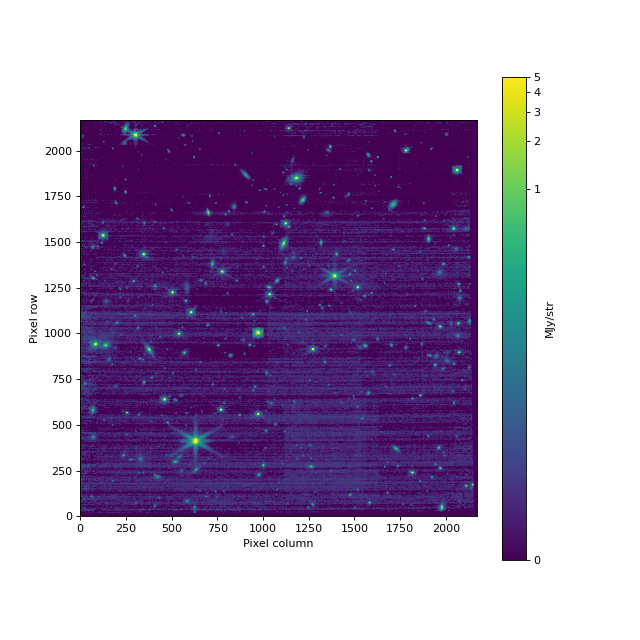

In [25]:
show_image(mosaic.data, vmin=0, vmax=5)

Let's look at the segmentation map that was created by the `source_catalog` step. This shows which pixels are associated with the identified sources.

In [26]:
seg_map = fits.getdata(segmentation_map_file)

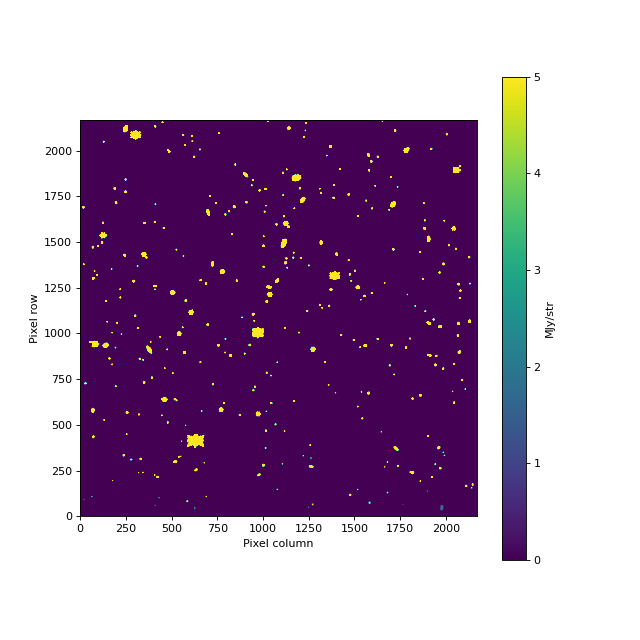

In [27]:
show_image(seg_map, vmin=0, vmax=5, scale='linear')

And now examine the actual source catalog. For each source, the catalog lists the location, along with flux and AB/Vega magnitude values in three different apertures, as well as calculated values for an infinite aperture. Within the documentation, you can see the [full list of column definitions](https://jwst-pipeline.readthedocs.io/en/stable/jwst/source_catalog/main.html#source-catalog-table).

In [28]:
source_cat = ascii.read(source_cat_file)

In [29]:
source_cat

label,xcentroid,ycentroid,sky_centroid,aper_bkg_flux,aper_bkg_flux_err,aper30_flux,aper30_flux_err,aper50_flux,aper50_flux_err,aper70_flux,aper70_flux_err,aper_total_flux,aper_total_flux_err,aper30_abmag,aper30_abmag_err,aper50_abmag,aper50_abmag_err,aper70_abmag,aper70_abmag_err,aper_total_abmag,aper_total_abmag_err,aper30_vegamag,aper30_vegamag_err,aper50_vegamag,aper50_vegamag_err,aper70_vegamag,aper70_vegamag_err,aper_total_vegamag,aper_total_vegamag_err,CI_50_30,CI_70_50,CI_70_30,is_extended,sharpness,roundness,nn_label,nn_dist,isophotal_flux,isophotal_flux_err,isophotal_abmag,isophotal_abmag_err,isophotal_vegamag,isophotal_vegamag_err,isophotal_area,semimajor_sigma,semiminor_sigma,ellipticity,orientation,sky_orientation,sky_bbox_ll,sky_bbox_ul,sky_bbox_lr,sky_bbox_ur
,,,"deg,deg",Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,,,,,,,,pix,Jy,Jy,,,,,pix2,pix,pix,,deg,deg,"deg,deg","deg,deg","deg,deg","deg,deg"
int64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float32,int64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,object,object,object,object
1,628.0369,20.9039,"12.005762281628577,11.982375359096071",0.000000e+00,1.475654e-10,1.916663e-07,4.444556e-02,3.534246e-07,6.479563e-02,5.884359e-07,1.200394e-01,8.672956e-07,1.769261e-01,25.693636,13.413211,25.029258,13.158128,24.475752,13.274067,24.054582,13.274067,22.451826,13.413211,21.787448,13.158128,21.233942,13.274067,20.812772,13.274067,1.8440,1.6650,3.0701,False,0.559770,0.156714,3,22.298339,5.468695e-07,9.926023e-02,24.555290,13.147235,21.313480,13.147235,21.0,1.129532,1.098490,0.027482,86.539384,176.542154,"12.005807682815261,11.982333268865881","12.005807691208815,11.982438314885187","12.005700297033798,11.982333277051335","12.00570030538551,11.982438323070667"
2,1977.0905,46.1415,"11.981617411372913,11.98281801801177",3.948023e-08,4.653435e-09,4.889877e-07,6.861507e-02,1.157743e-06,1.052071e-01,6.991654e-06,2.612258e-01,1.030500e-05,3.850207e-01,24.676755,12.867812,23.740970,12.396094,21.788550,11.431119,21.367380,11.431119,21.434945,12.867812,20.499160,12.396094,18.546740,11.431119,18.125570,11.431119,2.3676,6.0390,14.2982,True,0.563781,0.410921,16,120.058903,2.725173e-05,5.189156e-01,20.311514,10.699314,17.069704,10.699314,386.0,5.657700,2.497796,0.558514,88.372285,178.375054,"11.981771163483213,11.982526666046498","11.981771158452778,11.983069403802535","11.981431108282326,11.98252666285448","11.981431102567193,11.983069400609647"
3,626.3356,43.1372,"12.005792762113884,11.982764610772888",4.146603e-09,6.451832e-10,7.888856e-08,3.438654e-02,1.581537e-07,4.979459e-02,5.413784e-07,1.080957e-01,7.979376e-07,1.593222e-01,26.657465,14.098439,25.902301,13.745260,24.566248,13.250774,24.145078,13.250774,23.415655,14.098439,22.660491,13.745260,21.324438,13.250774,20.903268,13.250774,2.0048,3.4231,6.8626,True,0.557543,0.358286,1,22.298339,1.169078e-06,1.488153e-01,23.730391,12.762018,20.488581,12.762018,71.0,3.383830,1.379129,0.592435,-86.588842,3.413927,"12.00584350189702,11.982630896516635","12.00584352431712,11.982911019235921","12.00571821834701,11.98263090607833","12.005718240636902,11.982911028797727"
4,1249.0285,47.1601,"11.994648019667222,11.982835673051554",6.285735e-10,1.729542e-10,2.544352e-07,4.707191e-02,4.538742e-07,6.511572e-02,7.028355e-07,1.106449e-01,1.035909e-06,1.630795e-01,25.386057,13.167967,24.757661,12.891883,24.282866,12.992701,23.861696,12.992701,22.144247,13.167967,21.515851,12.891883,21.041056,12.992701,20.619886,12.992701,1.7839,1.5485,2.7623,False,0.632623,0.073333,6,27.596983,7.054509e-07,9.804362e-02,24.278831,12.857389,21.037022,12.857389,24.0,1.191887,1.122118,0.058536,89.941947,179.944716,"11.994693271848954,11.982789098668661","11.9946932765882,11.982911652359828",

Finally, let's overlay the source catalog on top of the mosaic image. In order to cut down on the number of spurious detections, we only show sources above a minimum flux limit. Another way to cut down on the number of spurious detections would be to change some of the `source_catalog` parameter values when calling the pipeline above.

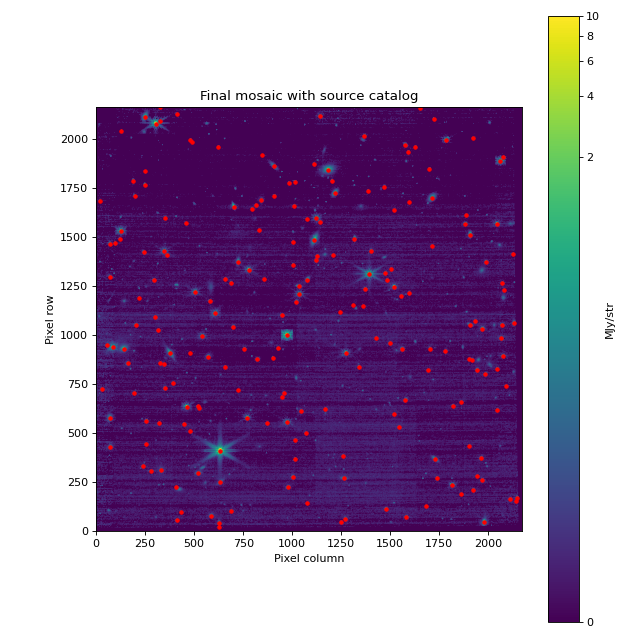

In [30]:
overlay_catalog(mosaic.data, source_cat, flux_limit=5e-7, vmin=0, vmax=10,
                title='Final mosaic with source catalog')

[Top of Page](#title_ID)

<a id='image3_step_by_step'></a>
# Run the individual pipeline steps

In the sections below we run the steps contained within calwebb_image3 one at a time, in order to check the outputs for each step.

<a id='tweakreg'></a>
### The `WCS refinement` step

#### Summary

This step, called the `tweakreg` step, mimics the behavior of the tweakreg step of Astrodrizzle. Given a series of images, it identifies point sources that are common to two or more images, and uses those sources' locations to correct the WCS of the input images. The tweaks are such that when the images are later combined into a final mosiac image, the WCS of the input images will align on the sky. 

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/tweakreg/README.html) of the step.

#### Arguments

There are many [optional input arguments](https://jwst-pipeline.readthedocs.io/en/stable/jwst/tweakreg/README.html#step-arguments).

#### Reference files used

This step does not use any reference files.

#### Parameter reference files

There are filter-dependent parameter reference files in CRDS for this step. 

#### Run the step

Since we ran the step above and saved the outputs, we'll skip this part and just load the outputs. 

Let's look at what parameters are available to be set.

In [31]:
print(TweakRegStep.spec)


        save_catalogs = boolean(default=False) # Write out catalogs?
        catalog_format = string(default='ecsv') # Catalog output file format
        kernel_fwhm = float(default=2.5) # Gaussian kernel FWHM in pixels
        snr_threshold = float(default=10.0) # SNR threshold above the bkg
        brightest = integer(default=1000) # Keep top ``brightest`` objects
        peakmax = float(default=None) # Filter out objects with pixel values >= ``peakmax``
        enforce_user_order = boolean(default=False) # Align images in user specified order?
        expand_refcat = boolean(default=False) # Expand reference catalog with new sources?
        minobj = integer(default=15) # Minimum number of objects acceptable for matching
        searchrad = float(default=1.0) # The search radius in arcsec for a match
        use2dhist = boolean(default=True) # Use 2d histogram to find initial offset?
        separation = float(default=0.5) # Minimum object separation in arcsec
        tolerance = f

In [32]:
# # Create instance, set parameters, and run
# tweakreg = TweakRegStep()
# tweakreg.kernel_fwhm = 2.302   # Gaussian FWHM in pixels
# tweakreg.snr_threshold = 10.0  # SNR threshold above background
# tweakreg.brightest = 100       # Number of brightest objects to keep
# tweakreg.save_results = True
# tweak = tweakreg.run(asn_file)

The step saves the results in new fits files with updated WCS information. Let's look at the difference in the WCS before and after the step by loading the WCS objects, and calculating the RA, Dec at one pixel.

In [33]:
cal_file = 'jw98765001001_01101_00003_nrcb5_cal.fits'
tweak_file = 'jw98765001001_01101_00003_nrcb5_tweakreg.fits'

In [34]:
# Open the files using datamodels
#with datamodels.open(cal_file) as cal_data:
cal_data = datamodels.open(cal_file)
print(type(cal_data))
#with datamodels.open(tweak_file) as tweak_data:
tweak_data = datamodels.open(tweak_file)
print(type(tweak_data))

<class 'jwst.datamodels.image.ImageModel'>
<class 'jwst.datamodels.image.ImageModel'>


In [35]:
cal_detector_to_world = cal_data.meta.wcs.get_transform('detector', 'world')
run_detector_to_world = tweak_data.meta.wcs.get_transform('detector', 'world')

Let's look at RA, Dec in the center of the detector.

In [36]:
x, y = (1024, 1024)

In [37]:
print(cal_detector_to_world(x, y))
print(run_detector_to_world(x, y))

(11.998691099172577, 12.000415018412108)
(11.998691000410755, 12.00041497779695)


In [38]:
# What is the shift in the WCS before/after this step?
delta_ra = run_detector_to_world(x, y)[0] - cal_detector_to_world(x, y)[0]
delta_dec = run_detector_to_world(x, y)[1] - cal_detector_to_world(x, y)[1]
print('Shift in RA, Dec is ({:.4f}, {:.4f}) arcsec'.format(delta_ra * 3600., delta_dec * 3600.))
print('This is ({:.3f}, {:.3f}) pixels.'.format(delta_ra * 3600. / .062, delta_dec * 3600. / 0.062))

Shift in RA, Dec is (-0.0004, -0.0001) arcsec
This is (-0.006, -0.002) pixels.


This extremely small shift is expected, since the simulated data used in this exercise has no jitter or offsets added to it.

Just for fun, let's look at the contents of the WCS object in one of the files saved by the tweakreg step.

In [39]:
tweak_data.meta.wcs

<WCS(output_frame=world, input_frame=detector, forward_transform=Model: CompoundModel
Inputs: ('x0', 'x1')
Outputs: ('lon', 'lat')
Model set size: 1
Expression: [0] & [1] | [2] & [3] | [4] | [5] & [6] | [7] | [8] & [9] | [10] & [11] | [12] | [13] & [14] | [15] | [16] | [17] / [18] | [19] | [20] | [21] | [22] & [23] | [24] | [25] | [26] & [27] | [28] & [29] | [30] | [31] | [32]
Components: 
    [0]: <Shift(offset=1.)>

    [1]: <Shift(offset=1.)>

    [2]: <Shift(offset=-1024.5)>

    [3]: <Shift(offset=-1024.5)>

    [4]: <Mapping((0, 1, 0, 1))>

    [5]: <Polynomial2D(5, c0_0=-0., c1_0=0.06287861, c2_0=-0.00000011, c3_0=0., c4_0=-0., c5_0=0., c0_1=0., c0_2=0.0000001, c0_3=0., c0_4=0., c0_5=-0., c1_1=-0.00000072, c1_2=0., c1_3=-0., c1_4=0., c2_1=0., c2_2=0., c2_3=-0., c3_1=-0., c3_2=0., c4_1=-0.)>

    [6]: <Polynomial2D(5, c0_0=0., c1_0=0.00008446, c2_0=0.00000031, c3_0=0., c4_0=0., c5_0=-0., c0_1=0.06317477, c0_2=-0.00000042, c0_3=0., c0_4=-0., c0_5=0., c1_1=-0.00000023, c1_2=0., c1_

[Top of Page](#title_ID)

<a id='skymatch'></a>
## The `Sky matching` step

#### Summary

This step calculates sky values in overlapping regions of the input images. Sky values can be computed for each image separately or in a way that matches the sky levels amongst the collection of images so as to minimize their differences.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/skymatch/README.html) of the step. Note that there are several possible methods for calculating the sky values. 

#### Arguments

There are [several optional arguments](https://jwst-pipeline.readthedocs.io/en/stable/jwst/skymatch/README.html#step-arguments) for this step.

#### Reference files used

This step does not use any reference files.

#### Parameter reference files
There are currently no parameter reference files for this step

#### Run the step

Since we ran the step above and saved the outputs, we'll skip this part and just load the outputs. 

        The easiest way to call this step is to supply the output object from the tweakreg call above. The other option would be to supply an association file. However, since the tweakreg step saved modified files, we would have to create a new association file that contains these new files, and then supply that association file in the call to skymatch. This pattern is the same for all of the steps in calwebb_image3, since all steps now expect association files for inputs, rather than individual files. 

        To create a new association file, follow the steps outlined in the [Creating your own association files](#diy_association) section above. Keep in mind that you could also simply make a copy of an existing association file and update the member filenames.

Let's also see what parameters are available to be set.

In [40]:
print(SkyMatchStep.spec)


        # General sky matching parameters:
        skymethod = option('local', 'global', 'match', 'global+match', default='global+match') # sky computation method
        match_down = boolean(default=True) # adjust sky to lowest measured value?
        subtract = boolean(default=False) # subtract computed sky from image data?

        # Image's bounding polygon parameters:
        stepsize = integer(default=None) # Max vertex separation

        # Sky statistics parameters:
        skystat = option('median', 'midpt', 'mean', 'mode', default='mode') # sky statistics
        dqbits = string(default=0) # "good" DQ bits
        lower = float(default=None) # Lower limit of "good" pixel values
        upper = float(default=None) # Upper limit of "good" pixel values
        nclip = integer(min=0, default=5) # number of sky clipping iterations
        lsigma = float(min=0.0, default=4.0) # Lower clipping limit, in sigma
        usigma = float(min=0.0, default=4.0) # Upper clipping limit, in s

In [41]:
# skymatch = SkyMatchStep()
# skymatch.skymethod = 'global+match' # this is the default. Set here as an example
# skymatch.save_results = True
# sky = skymatch.run(tweak)

If you request to save the output from this step, two new header keywords are added to the primary header of the outputs. In each file, the `BKGLEVEL` keyword lists the computed background level, and the `BKGSUB` keyword says whether or not the background has been subtracted from the data.

In this case, we kept the default behavior of not subtracting the background from the data, as shown below.

In [42]:
# sky_file = 'step_SkyMatchStep_2_skymatchstep.fits'
sky_file = 'l3_lw_results_2_skymatch.fits'

In [43]:
sky_header = fits.getheader(sky_file, 0)
print('Computed background level: {}'.format(sky_header['BKGLEVEL']))
print('Background subtracted: {}'.format(sky_header['BKGSUB']))

Computed background level: 0.2703646668195906
Background subtracted: False


Here we see that the calculated background value is not subtracted from the input data:

In [44]:
#with datamodels.open(sky_file) as sky_data:
sky_data = datamodels.open(sky_file)
print(sky_data.info())

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.8.3
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): c9f6823a6e4061c05ece6d410560931531b140a90c957fc7941f364e1f9d1afc
├─area (NDArrayType): shape=(2048, 2048), dtype=float32
├─data (NDArrayType): shape=(2048, 2048), dtype=float32
├─dq (NDArrayType): shape=(2048, 2048), dtype=uint32
├─err (NDArrayType): shape=(2048, 2048), dtype=float32
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─asn (dict) ...
│ ├─background (dict) ...
│ ├─bunit_data (str): MJy/sr
│ ├─bunit_err (str): MJy/sr
│ └─25 not shown
├─var_flat (NDArrayType): shape=(2048, 2048), dtype=float32
├─var_poisson (NDArrayType): shape=(2048, 2048), dtype=float32
└─var_rnoise (NDArrayType): shape=(2048, 2048), dtype=float32
Some nodes not shown.
None


In [45]:
np.min(sky_data.data - cal_data.data), np.max(sky_data.data - cal_data.data)

(0.0, 0.0)

In [46]:
sky_data.close()

[Top of Page](#title_ID)

<a id='outlier_detection'></a>
## The `Outlier Detection` step

#### Summary

This step uses the collection of input files to identify and flag any cosmic rays or other transient image artifacts that were not flagged by the jump step in calwebb_detector1. While the jump step looked for large pixel-based deviations in the signal from group-to-group within an integration, the outlier detection step looks for large sky-based exposure-to-exposure devations in the signal. If a given location on the sky shows no signal above the noise in 4 out of 5 exposures, but a bright source in the remaining exposure, the outlier detction step will flag in the DQ map the pixels containing the source in the fifth exposure. These pixels will be ignored when the exposures are later combined into a final mosaic image.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/outlier_detection/main.html) of the step.

#### Arguments

There are [numerous optional arguments](https://jwst-pipeline.readthedocs.io/en/stable/jwst/outlier_detection/arguments.html) for this step, including several that apply to the resample step, which this step makes use of.


#### Reference files used

This step does not use any reference files.

#### Run the step

Since we ran the step above and saved the outputs, we'll skip this part and just load the outputs. 

List the available parameters:

In [47]:
print(OutlierDetectionStep.spec)


        weight_type = option('ivm','exptime',default='ivm')
        pixfrac = float(default=1.0)
        kernel = string(default='square') # drizzle kernel
        fillval = string(default='INDEF')
        nlow = integer(default=0)
        nhigh = integer(default=0)
        maskpt = float(default=0.7)
        grow = integer(default=1)
        snr = string(default='5.0 4.0')
        scale = string(default='1.2 0.7')
        backg = float(default=0.0)
        save_intermediate_results = boolean(default=False)
        resample_data = boolean(default=True)
        good_bits = string(default="~DO_NOT_USE")  # DQ flags to allow
        scale_detection = boolean(default=False)
        search_output_file = boolean(default=False)
        allowed_memory = float(default=None)  # Fraction of memory to use for the combined image.
    


In [48]:
# # Run the step
# outlier_detection = OutlierDetectionStep()
# outlier_detection.save_results = True
# outlier = outlier_detection.run(sky)

In [49]:
# outlier_file = 'step_SkyMatchStep_2_a3001_outlierdetectionstep.fits'
outlier_file = 'l3_lw_results_2_a3001_crf.fits'

In [50]:
# Open using datamodels
#with datamodels.open(outlier_file) as outlier_data:
outlier_data = datamodels.open(outlier_file)
print(outlier_data.info())

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.8.3
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): eb340d378f9864fac140eb289c2248350fb07230738b02ea12e19afd369c00c7
├─area (NDArrayType): shape=(2048, 2048), dtype=float32
├─data (NDArrayType): shape=(2048, 2048), dtype=float32
├─dq (NDArrayType): shape=(2048, 2048), dtype=uint32
├─err (NDArrayType): shape=(2048, 2048), dtype=float32
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─asn (dict) ...
│ ├─background (dict) ...
│ ├─bunit_data (str): MJy/sr
│ ├─bunit_err (str): MJy/sr
│ └─25 not shown
├─var_flat (NDArrayType): shape=(2048, 2048), dtype=float32
├─var_poisson (NDArrayType): shape=(2048, 2048), dtype=float32
└─var_rnoise (NDArrayType): shape=(2048, 2048), dtype=float32
Some nodes not shown.
None


In [51]:
# Get a list of pixels where DQ flags were changed
new_flags = np.where(cal_data.dq != outlier_data.dq)

In [52]:
print("Found {} pixels with updated DQ flag values.".format(len(new_flags[0])))

Found 25569 pixels with updated DQ flag values.


Let's have a look at the DQ value for one of these pixels before and after the outlier detection step has run, in order to see what has changed.

In [53]:
index = 12515
y = new_flags[0][index]
x = new_flags[1][index]
print('Pixel x, y = ({}, {})'.format(x, y))
print('Before: {}'.format(cal_data.dq[y, x]))
print('After: {}'.format(outlier_data.dq[y, x]))

Pixel x, y = (748, 1072)
Before: 1311751
After: 1311767


Below we see that the 'OUTLIER' and the 'DO_NOT_USE' flags are new. 

In [54]:
find_bad_pix_types(cal_data.dq[y, x])

([1, 2, 4, 1024, 262144, 1048576],
 ['DO_NOT_USE',
  'SATURATED',
  'JUMP_DET',
  'DEAD',
  'NO_FLAT_FIELD',
  'NO_LIN_CORR'])

In [55]:
find_bad_pix_types(outlier_data.dq[y, x])

([1, 2, 4, 16, 1024, 262144, 1048576],
 ['DO_NOT_USE',
  'SATURATED',
  'JUMP_DET',
  'OUTLIER',
  'DEAD',
  'NO_FLAT_FIELD',
  'NO_LIN_CORR'])

The image data itself remains unchanged.

In [56]:
print(cal_data.data[y, x], outlier_data.data[y, x])

0.0 0.0


When the Resample step is run next in order to create the final mosaic image, all pixels flagged as DO_NOT_USE will be ignored.

[Top of Page](#title_ID)

<a id='resample'> </a>
## The `Resample` step

#### Summary

We initially saw this step in calwebb_image2, where it was used to resample individual images onto a distortion-free pixel grid. This time, the Resample step works on the set of input images, which now all have a consistent WCS, thanks to the tweakreg step. The input images are combined into a final mosaic as they are resampled onto a distortion-free grid. The output of this step is the final image output of the Stage 3 pipeline. 

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/resample/main.html) of the step.

#### Arguments

There is a list of [optional Astrodrizzle-style](https://jwst-pipeline.readthedocs.io/en/stable/jwst/resample/arguments.html) input parameters that can be used to customize the resampling process.

#### Reference files used

This step uses the [`DRIZPARS`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/resample/reference_files.html) reference file. This file contains Astrodrizzle-style keywords that can be used to control the details of the resampling.

#### Run the step

Since we ran the step above and saved the outputs, we'll skip this part and just load the outputs. 

List the available parameters and their default values:

In [57]:
print(ResampleStep.spec)


        pixfrac = float(default=1.0)
        kernel = string(default='square')
        fillval = string(default='INDEF')
        weight_type = option('ivm', 'exptime', default='ivm')
        pixel_scale_ratio = float(default=1.0) # Ratio of output to input pixel scale
        single = boolean(default=False)
        blendheaders = boolean(default=True)
        allowed_memory = float(default=None)  # Fraction of memory to use for the combined image.
    


In [58]:
# # Run the step
# resample = ResampleStep()
# resample.save_results = True
# resamp = resample.run(outlier)

In [59]:
# resamp_file = 'step_ResampleStep_resamplestep.fits'
resamp_file = 'l3_lw_results_i2d.fits'

#with datamodels.open(resamp_file) as resamp:
resamp = datamodels.open(resamp_file)
print(resamp.info())

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.8.3
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): fd8266069c5c103c7d7bc42f51dbab0fa28abac3808f4ed0019b2ea7bbb3687b
├─con (ndarray): shape=(2166, 2170), dtype=int32
├─data (ndarray): shape=(2166, 2170), dtype=float32
├─err (ndarray): shape=(2166, 2170), dtype=float32
├─hdrtab (NDArrayType): shape=(3,), dtype=void29720
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─asn (dict) ...
│ ├─background (dict) ...
│ ├─bunit_data (str): MJy/sr
│ └─28 not shown
├─var_flat (ndarray): shape=(2166, 2170), dtype=float32
├─var_poisson (ndarray): shape=(2166, 2170), dtype=float32
├─var_rnoise (ndarray): shape=(2166, 2170), dtype=float32
└─wht (ndarray): shape=(2166, 2170), dtype=float32
Some nodes not shown.
None


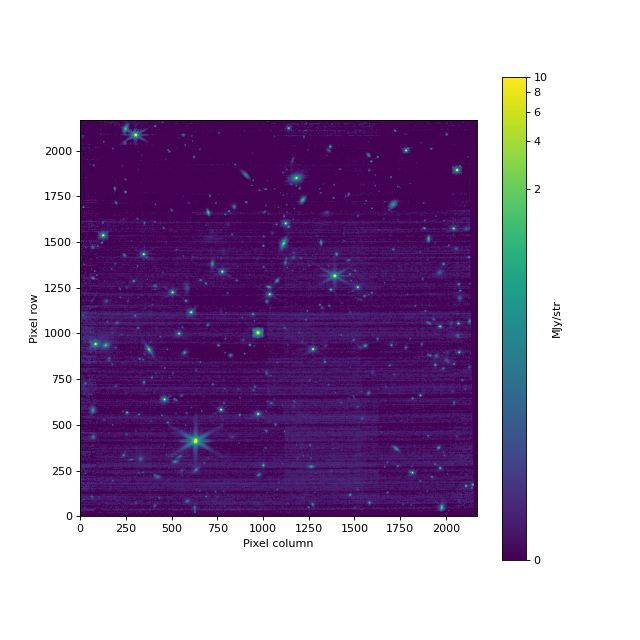

In [60]:
show_image(resamp.data, 0, 10)

In [61]:
resamp.data.shape

(2166, 2170)

[Top of Page](#title_ID)

<a id='source_catalog'> </a>
## The `Source Catalog` step

#### Summary

This step creates a catalog of source photometry and morphology information. Sources are identified using [Photutils' image segmentation](https://photutils.readthedocs.io/en/latest/segmentation.html) method. The output is an ASCII file containing a table of source locations and aperture photometry results.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/source_catalog/main.html) of the step.

#### Arguments

There is a list of [optional input parameters](https://jwst-pipeline.readthedocs.io/en/stable/jwst/source_catalog/arguments.html) that can be used to customize the resampling process.

#### Reference files used

This step uses the [`APCORR` and `ABVEGAOFFSET`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/source_catalog/reference_files.html) reference files. The `APCORR` reference file contains the factors necessary to correct aperture photometry results to the equivalent of an infinite aperure. The `ABVEGAOFFSET` reference file contains data necessary for converting from AB to Vega magnitudes.

<a id='srccat_run'></a>
#### Run the step with the run() method

Since we ran the step above and saved the outputs, we'll skip this part and just load the outputs. 

List the available parameters and their default values:

In [62]:
print(SourceCatalogStep.spec)


        bkg_boxsize = integer(default=100)    # background mesh box size in pixels
        kernel_fwhm = float(default=2.0)      # Gaussian kernel FWHM in pixels
        snr_threshold = float(default=3.0)    # SNR threshold above the bkg
        npixels = integer(default=5)          # min number of pixels in source
        deblend = boolean(default=False)      # deblend sources?
        aperture_ee1 = integer(default=30)    # aperture encircled energy 1
        aperture_ee2 = integer(default=50)    # aperture encircled energy 2
        aperture_ee3 = integer(default=70)    # aperture encircled energy 3
        ci1_star_threshold = float(default=2.0)  # CI 1 star threshold
        ci2_star_threshold = float(default=1.8)  # CI 2 star threshold
        suffix = string(default='cat')        # Default suffix for output files
    


In [63]:
# Run the step after setting some parameters
srccat = SourceCatalogStep()
srccat.save_results = True
srccat.kernel_fwhm = 2.302  # pixels
srccat.snr_threshold = 10.

source_cat = srccat.run(resamp_file)

2022-01-27 19:39:01,621 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.


2022-01-27 19:39:01,733 - stpipe.SourceCatalogStep - INFO - Step SourceCatalogStep running with args ('l3_lw_results_i2d.fits',).


2022-01-27 19:39:01,735 - stpipe.SourceCatalogStep - INFO - Step SourceCatalogStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 100, 'kernel_fwhm': 2.302, 'snr_threshold': 10.0, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2022-01-27 19:39:02,170 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file /grp/crds/cache/references/jwst/jwst_nircam_apcorr_0004.fits


2022-01-27 19:39:02,390 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file /grp/crds/cache/references/jwst/jwst_nircam_abvegaoffset_0001.asdf


2022-01-27 19:39:02,392 - stpipe.SourceCatalogStep - INFO - Instrument: NIRCAM


2022-01-27 19:39:02,392 - stpipe.SourceCatalogStep - INFO - Detector: NRCBLONG


2022-01-27 19:39:02,393 - stpipe.SourceCatalogStep - INFO - Filter: F444W


2022-01-27 19:39:02,394 - stpipe.SourceCatalogStep - INFO - Pupil: CLEAR


2022-01-27 19:39:02,394 - stpipe.SourceCatalogStep - INFO - Subarray: FULL


2022-01-27 19:39:02,446 - stpipe.SourceCatalogStep - INFO - AB to Vega magnitude offset 3.24181


2022-01-27 19:39:04,364 - stpipe.SourceCatalogStep - INFO - Detected 340 sources


2022-01-27 19:39:05,235 - stpipe.SourceCatalogStep - INFO - Wrote source catalog: l3_lw_results_cat.ecsv


2022-01-27 19:39:05,374 - stpipe.SourceCatalogStep - INFO - Saved model in l3_lw_results_segm.fits


2022-01-27 19:39:05,376 - stpipe.SourceCatalogStep - INFO - Wrote segmentation map: l3_lw_results_segm.fits


2022-01-27 19:39:05,378 - stpipe.SourceCatalogStep - INFO - Step SourceCatalogStep done


#### Examine the results

In [64]:
source_cat

label,xcentroid,ycentroid,sky_centroid,aper_bkg_flux,aper_bkg_flux_err,aper30_flux,aper30_flux_err,aper50_flux,aper50_flux_err,aper70_flux,aper70_flux_err,aper_total_flux,aper_total_flux_err,aper30_abmag,aper30_abmag_err,aper50_abmag,aper50_abmag_err,aper70_abmag,aper70_abmag_err,aper_total_abmag,aper_total_abmag_err,aper30_vegamag,aper30_vegamag_err,aper50_vegamag,aper50_vegamag_err,aper70_vegamag,aper70_vegamag_err,aper_total_vegamag,aper_total_vegamag_err,CI_50_30,CI_70_50,CI_70_30,is_extended,sharpness,roundness,nn_label,nn_dist,isophotal_flux,isophotal_flux_err,isophotal_abmag,isophotal_abmag_err,isophotal_vegamag,isophotal_vegamag_err,isophotal_area,semimajor_sigma,semiminor_sigma,ellipticity,orientation,sky_orientation,sky_bbox_ll,sky_bbox_ul,sky_bbox_lr,sky_bbox_ur
,,,"deg,deg",Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,,,,,,,,pix,Jy,Jy,,,,,pix2,pix,pix,,deg,deg,"deg,deg","deg,deg","deg,deg","deg,deg"
int64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float32,int64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,object,object,object,object
1,628.0369,20.9039,"12.005762281628577,11.982375359096071",0.000000e+00,1.475654e-10,1.916663e-07,4.444556e-02,3.534246e-07,6.479563e-02,5.884359e-07,1.200394e-01,8.672956e-07,1.769261e-01,25.693636,13.413211,25.029258,13.158128,24.475752,13.274067,24.054582,13.274067,22.451826,13.413211,21.787448,13.158128,21.233942,13.274067,20.812772,13.274067,1.8440,1.6650,3.0701,False,0.559770,0.156714,3,22.298339,5.468695e-07,9.926023e-02,24.555290,13.147235,21.313480,13.147235,21.0,1.129532,1.098490,0.027482,86.539384,176.542154,"12.005807682815261,11.982333268865881","12.005807691208815,11.982438314885187","12.005700297033798,11.982333277051335","12.00570030538551,11.982438323070667"
2,1977.0905,46.1415,"11.981617411372913,11.98281801801177",3.948023e-08,4.653435e-09,4.889877e-07,6.861507e-02,1.157743e-06,1.052071e-01,6.991654e-06,2.612258e-01,1.030500e-05,3.850207e-01,24.676755,12.867812,23.740970,12.396094,21.788550,11.431119,21.367380,11.431119,21.434945,12.867812,20.499160,12.396094,18.546740,11.431119,18.125570,11.431119,2.3676,6.0390,14.2982,True,0.563781,0.410921,16,120.058903,2.725173e-05,5.189156e-01,20.311514,10.699314,17.069704,10.699314,386.0,5.657700,2.497796,0.558514,88.372285,178.375054,"11.981771163483213,11.982526666046498","11.981771158452778,11.983069403802535","11.981431108282326,11.98252666285448","11.981431102567193,11.983069400609647"
3,626.3356,43.1372,"12.005792762113884,11.982764610772888",4.146603e-09,6.451832e-10,7.888856e-08,3.438654e-02,1.581537e-07,4.979459e-02,5.413784e-07,1.080957e-01,7.979376e-07,1.593222e-01,26.657465,14.098439,25.902301,13.745260,24.566248,13.250774,24.145078,13.250774,23.415655,14.098439,22.660491,13.745260,21.324438,13.250774,20.903268,13.250774,2.0048,3.4231,6.8626,True,0.557543,0.358286,1,22.298339,1.169078e-06,1.488153e-01,23.730391,12.762018,20.488581,12.762018,71.0,3.383830,1.379129,0.592435,-86.588842,3.413927,"12.00584350189702,11.982630896516635","12.00584352431712,11.982911019235921","12.00571821834701,11.98263090607833","12.005718240636902,11.982911028797727"
4,1249.0285,47.1601,"11.994648019667222,11.982835673051554",6.285735e-10,1.729542e-10,2.544352e-07,4.707191e-02,4.538742e-07,6.511572e-02,7.028355e-07,1.106449e-01,1.035909e-06,1.630795e-01,25.386057,13.167967,24.757661,12.891883,24.282866,12.992701,23.861696,12.992701,22.144247,13.167967,21.515851,12.891883,21.041056,12.992701,20.619886,12.992701,1.7839,1.5485,2.7623,False,0.632623,0.073333,6,27.596983,7.054509e-07,9.804362e-02,24.278831,12.857389,21.037022,12.857389,24.0,1.191887,1.122118,0.058536,89.941947,179.944716,"11.994693271848954,11.982789098668661","11.9946932765882,11.982911652359828",

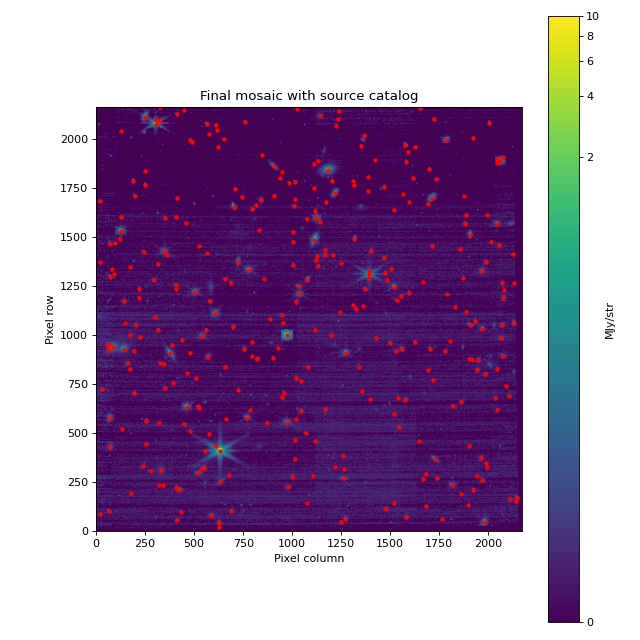

In [65]:
overlay_catalog(resamp.data, source_cat, flux_limit=0, vmin=0, vmax=10,
                title='Final mosaic with source catalog')

[Top of Page](#title_ID)

<a id="about_ID"></a>
## About this Notebook
**Original Author:** Bryan Hilbert, updated by Alicia Canipe, NIRCam
<br>**Updated On:** 07/28/2021

[Top of Notebook](#title_ID)